In [1]:
import torch
import numpy as np
torch.manual_seed(7)
np.random.seed(7)

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [14]:
from torch import nn
from torch import optim
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Connection (with Layer)
        self.hidden1 = nn.Linear(784, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.outputs = nn.Linear(64, 10)
        
        # Comming Soon!
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Set inputs shape: samples (batch_size) x features
        x = x.view(x.shape[0], -1) # --> inputs data must be flatten 1x28x18 --> samples x 784
        
        # Activation for each connection
        x = self.dropout(F.relu(self.hidden1(x)))
        x = self.dropout(F.relu(self.hidden2(x)))
        x = self.dropout(F.relu(self.hidden3(x)))
        x = F.log_softmax(self.outputs(x), dim=1)
        
        return x

In [37]:
### Check
model = Network()

# images, labels = next(iter(testloader))

#1. Get the class probabilities
# ps = torch.exp(model(images))
# print(ps.shape)            # 64x10

# top_p, top_class = ps.topk(10, dim=1)
# print(top_p.shape)         # 64x1
# print(top_class.shape)     # 64x1
# accuracy = top_class == labels.view(-1, 1)
# accuracy = accuracy.numpy()
# print(np.mean(accuracy)*100.0)
# print(top_p, top_class)
# print(top_p)
print(model)
print(model.state_dict().keys())

Network(
  (hidden1): Linear(in_features=784, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (outputs): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)
odict_keys(['hidden1.weight', 'hidden1.bias', 'hidden2.weight', 'hidden2.bias', 'hidden3.weight', 'hidden3.bias', 'outputs.weight', 'outputs.bias'])


In [25]:
model = Network()
criterion = nn.NLLLoss() # Negative Log-Likelihood Loss --> L(y) = -log(y)
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10 # Set 100
steps = 0

train_losses, test_losses = [], []

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()   # Clear off the gradient (w = w - gradient)
        
        log_ps = model(images)  # log class probabilities [People use --> outputs = model(inputs)]
        loss = criterion(log_ps, labels) 
        loss.backward()                  # Backpropagation 
        optimizer.step()                 # Update the weights
        
        running_loss += loss.item()      # Accumulate the loss
    
    ### ------ ###
    
    test_loss = 0
    accuracy = 0

    with torch.no_grad(): # Turn off gradients for validation, saves memory and computations
        
        model.eval() # Set model to evaluation mode
        ### ------ ###
        
        for images, labels in testloader:
            
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            
            equals = ( top_class == labels.view(top_class.shape) )
            
            accuracy += np.mean(equals.numpy())

    model.train() # Set model back to train mode
    ### ------ ###
    
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}... ".format(epoch+1, epochs),
          "Training Loss: {:.3f}... ".format(running_loss/len(trainloader)),
          "Test Loss: {:.3f}... ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/10...  Training Loss: 0.606...  Test Loss: 0.488...  Test Accuracy: 0.827
Epoch: 2/10...  Training Loss: 0.484...  Test Loss: 0.467...  Test Accuracy: 0.834
Epoch: 3/10...  Training Loss: 0.452...  Test Loss: 0.434...  Test Accuracy: 0.845
Epoch: 4/10...  Training Loss: 0.432...  Test Loss: 0.422...  Test Accuracy: 0.852
Epoch: 5/10...  Training Loss: 0.423...  Test Loss: 0.417...  Test Accuracy: 0.846
Epoch: 6/10...  Training Loss: 0.411...  Test Loss: 0.403...  Test Accuracy: 0.850
Epoch: 7/10...  Training Loss: 0.400...  Test Loss: 0.408...  Test Accuracy: 0.858
Epoch: 8/10...  Training Loss: 0.402...  Test Loss: 0.428...  Test Accuracy: 0.849
Epoch: 9/10...  Training Loss: 0.395...  Test Loss: 0.388...  Test Accuracy: 0.860
Epoch: 10/10...  Training Loss: 0.394...  Test Loss: 0.397...  Test Accuracy: 0.863


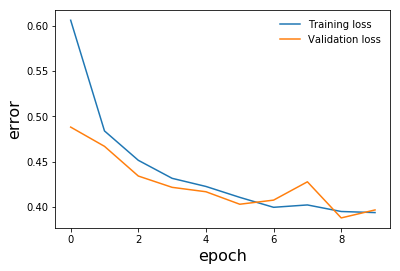

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.xlabel('epoch', fontsize=16)
plt.ylabel('error', fontsize=16)
plt.legend(frameon=False)

In [28]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

    ps = torch.exp(output)
    
    print(ps)
# Plot the image and probabilities
# helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')



tensor([[ 6.5726e-19,  3.6458e-20,  2.4731e-23,  5.7509e-24,  1.9501e-24,
          1.5677e-05,  2.6114e-18,  2.7944e-04,  2.0117e-17,  9.9970e-01]])
